# EGNN Model and Layer Implementation and Application

E(n) Equivariant Graph Neural Networks

The EGNN is using coordinates to update features and use features to update coordinates in an equivariant way. 

Basically if the model only considers the `radial` of the coordinates, it will be equivariant by default.. 

In [163]:
import os, torch

import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
from torch import nn
from torch import sin, cos, atan2, acos
from torch.utils.data import DataLoader
from torch.optim import Adam

## 1. EGNN Layers

In [57]:
# helper functions, basically torch scatter
def unsorted_segment_sum(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result


def unsorted_segment_mean(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

In [18]:
# MLP and GCN
class MLP(nn.Module): 
    
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim), 
                                 nn.LeakyReLU(0.2), 
                                 nn.Linear(hidden_dim, hidden_dim), 
                                 nn.LeakyReLU(0.2), 
                                 nn.Linear(hidden_dim, hidden_dim), 
                                 nn.LeakyReLU(0.2), 
                                 nn.Linear(hidden_dim, output_dim))
    def forward(self, x): 
        return self.net(x)

# Base class of Graph Convolution
class GCNBase(nn.Module): 
    
    def __init__(self): 
        super(GCNBase, self).__init__()
    
    def egde_model(self, source, target, edge_attr): pass
    def node_model(self, h, edge_index, edge_attr): pass

    def forward(self, x, edge_index, edge_attr=None): 
        row, col = edge_index
        edge_feat = self.edge_model(x[row], x[col], edge_attr)
        x = self.node_model(x, edge_index, edge_feat)
        return x, edge_feat
    

# GCN with edge features
class GCN(GCNBase): 
    
    def __init__(self, input_dim, output_dim, hidden_dim, 
                       edge_attr_dim=0, act_fn=nn.ReLU(), bias=True, attention=False, t_eq=False):
        super(GCN, self).__init__()

        self.attention = attention
        self.t_eq = t_eq

        self.edge_mlp = nn.Sequential(nn.Linear(2 * input_dim + edge_attr_dim, hidden_dim, bias=bias), 
                                      act_fn, 
                                      nn.Linear(hidden_dim, hidden_dim, bias=bias),
                                      act_fn)

        if self.attention: 
            self.attn_mlp = nn.Sequential(nn.Linear(input_dim, hidden_dim, bias=bias), 
                                          nn.Linear(hidden_dim, 1, bias=bias),
                                          nn.Sigmoid())

        self.node_mlp = nn.Sequential(nn.Linear(input_dim + hidden_dim, hidden_dim, bias=bias), 
                                      act_fn,
                                      nn.Linear(hidden_dim, output_dim, bias=bias))
    
    def edge_model(self, source, target, edge_attr):
        edge_in = torch.cat([source, target], dim=1)
        if edge_attr is not None: edge_in = torch.cat([edge_in, edge_attr], dim=1)
        out = self.edge_mlp(edge_in)
        if self.attention:
            attn = self.attn_mlp(torch.abs(source - target))
            out = out * attn
        return out
    
    def node_model(self, h, edge_index, edge_attr): 
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=h.size(0))
        out = torch.cat([h, agg], dim=1)
        out = self.node_mlp(out)
        return out

    

In [45]:
# Radial Field GCN
class RFGCN(GCNBase):
    
    def __init__(self, input_dim=64, edge_attr_dim=0, reg=0, act_fn=nn.LeakyReLU(0.2), clamp=False):
        super(RFGCN, self).__init__()
        
        self.clamp = clamp
        layer = nn.Linear(input_dim, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)
        self.phi = nn.Sequential(nn.Linear(1 + edge_attr_dim, input_dim),
                                 act_fn, 
                                 layer)
        self.reg = reg
        
    def edge_model(self, source, target, edge_attr): 
        x_diff = source - target
        radial = torch.sqrt(torch.sum(x_diff ** 2, dim=1)).unsqueeze(1)
        e_input = torch.cat([radial, edge_attr], dim=1)
        e_out = self.phi(e_input)
        m_ij = x_diff * e_out
        if self.clamp: m_ij = torch.clamp(m_ij, min=-100, max=100)
        return m_ij
    
    def node_model(self, x, edge_index, edge_attr): 
        row, col = edge_index
        agg = unsorted_segment_mean(edge_attr, row, num_segments=x.size(0))
        x_out = x + agg - x * self.reg
        return x_out

# EGNN
class EGCN(nn.Module): 
    
    def __init__(self, input_dim, output_dim, hidden_dim, edge_attr_dim=0, act_fn=nn.ReLU(), coord_weight=1.0,
                       attention=False, clamp=False, norm_diff=False, tanh=False): 
        super(EGCN, self).__init__()
        
        self.coord_weight = coord_weight
        self.attention = attention
        self.norm_diff = norm_diff
        self.tanh = tanh
        self.clamp = clamp
        edge_coord_dim = 1
        
        self.edge_mlp = nn.Sequential(nn.Linear(2 * input_dim + edge_coord_dim + edge_attr_dim, hidden_dim),
                                      act_fn,
                                      nn.Linear(hidden_dim, hidden_dim),
                                      act_fn)
        
        self.node_mlp = nn.Sequential(nn.Linear(hidden_dim + input_dim, hidden_dim),
                                      act_fn,
                                      nn.Linear(hidden_dim, output_dim))
        
        layer = nn.Linear(hidden_dim, 1, bias=False)
        nn.init.xavier_uniform_(layer.weight, gain=0.001)
        
        coord_mlp = []
        coord_mlp.append(nn.Linear(hidden_dim, hidden_dim))
        coord_mlp.append(act_fn)
        coord_mlp.append(layer)
        if self.tanh: 
            coord_mlp.append(nn.Tanh())
            self.coord_range = nn.Parameter(torch.ones(1)) * 3
        self.coord_mlp = nn.Sequential(*coord_mlp)
        
        if self.attention: 
            self.attn_mlp = nn.Sequential(nn.Linear(hidden_dim, 1), nn.Sigmoid())
    
    def edge_model(self, source, target, radial, edge_attr): 
        
        if edge_attr is None: out = torch.cat([source, target, radial], dim=1)
        else: out = torch.cat([source, target, radial, edge_attr], dim=1)
        
        out = self.edge_mlp(out)
        if self.attention: out = out * self.attn_mlp(out)
        return out
    
    def node_model(self, x, edge_index, edge_attr, node_attr): 
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        if node_attr is None: agg = torch.cat([x, agg], dim=1)
        else: agg = torch.cat([x, agg, node_attr])
        out = self.node_mlp(agg)
        # out = out + x
        return out, agg
        
        
    
    def coord_model(self, coord, edge_index, coord_diff, edge_feat): 
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat)
        trans = torch.clamp(trans, min=-100, max=100)
        agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        coord = coord + agg * self.coord_weight
        return coord
    
    def coord2radial(self, edge_index, coord): 
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum(coord_diff ** 2, 1).unsqueeze(1)
        
        if self.norm_diff: 
            norm = torch.sqrt(radial) + 1
            coord_diff = coord_diff / norm
        return radial, coord_diff
    
    def forward(self, h, edge_index, coord, edge_attr=None, node_attr=None): 
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)
        
        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        
        return h, coord, edge_feat
            
        

In [46]:
# EGCN Velocity
class EGCNVel(EGCN): 
    
    def __init__(self, input_dim, output_dim, hidden_dim, edge_attr_dim=0, act_fn=nn.ReLU(), coord_weight=1.0,
                       attention=False, norm_diff=False, tanh=False): 
        EGCN.__init__(self, input_dim, output_dim, hidden_dim, edge_attr_dim=edge_attr_dim, 
                                            act_fn=act_fn, coord_weight=coord_weight, attention=attention, norm_diff=norm_diff, tanh=tanh)
        
        self.norm_diff = norm_diff
        self.coord_mlp_vel = nn.Sequential(nn.Linear(input_dim, hidden_dim), 
                                           act_fn, 
                                           nn.Linear(hidden_dim, 1))
        
    def forward(self, h, edge_index, coord, vel, edge_attr=None, node_attr=None): 
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)
        
        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        
        coord = coord + self.coord_mlp_vel(h) * vel
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        return h, coord, edge_feat
        

### Testing Layers

In [22]:
# data

INPUT_DIM = 128
OUTPUT_DIM = 32
HIDDEN_DIM = 64
EDGE_ATTR_DIM = 4

NUM_NODES = 100
NUM_EDGES = 500
N_SPACE = 3

x = torch.randn(NUM_NODES, INPUT_DIM)
coord = torch.randn(NUM_NODES, N_SPACE)
vel = torch.randn(NUM_NODES, N_SPACE)
edge_index = torch.cat([torch.randint(0, NUM_NODES, (1, NUM_EDGES)), torch.randint(0, NUM_NODES, (1, NUM_EDGES))], dim=0)
edge_attr = torch.randn(NUM_EDGES, EDGE_ATTR_DIM)

In [49]:
# mlp
mlp_test = MLP(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM)
mlp_out = mlp_test(x)
print('MLP: ', mlp_out.shape)

# gcn
gcn_test = GCN(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, edge_attr_dim=EDGE_ATTR_DIM)
gcn_node_out, gcn_edge_out = gcn_test(x, edge_index, edge_attr=edge_attr)
print('GCN: ', gcn_node_out.shape, gcn_edge_out.shape)

# rfgcn
rfgcn_test = RFGCN(INPUT_DIM, edge_attr_dim=EDGE_ATTR_DIM)
rfgcn_node_out, rfgcn_edge_out = rfgcn_test(x, edge_index, edge_attr)
print('RFGCN: ', rfgcn_node_out.shape, rfgcn_edge_out.shape)

# egcn
egcn_test = EGCN(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, edge_attr_dim=EDGE_ATTR_DIM, attention=True)
egcn_node_out, egcn_coord_out, egcn_edge_out = egcn_test(x, edge_index, coord, edge_attr=edge_attr)
print('EGCN: ', egcn_node_out.shape, egcn_coord_out.shape, egcn_edge_out.shape)

# egcnvel
egcnvel_test = EGCNVel(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, edge_attr_dim=EDGE_ATTR_DIM, attention=True)
egcnvel_node_out, egcnvel_coord_out, egcnvel_edge_out = egcnvel_test(x, edge_index, coord, vel, edge_attr=edge_attr)
print('EGCNVel: ', egcnvel_node_out.shape, egcnvel_coord_out.shape, egcnvel_edge_out.shape)



MLP:  torch.Size([100, 32])
GCN:  torch.Size([100, 32]) torch.Size([500, 64])
RFGCN:  torch.Size([100, 128]) torch.Size([500, 128])
EGCN:  torch.Size([100, 32]) torch.Size([100, 3]) torch.Size([500, 64])
EGCNVel:  torch.Size([100, 32]) torch.Size([100, 3]) torch.Size([500, 64])


### Testing Equivariant

In [67]:
def rot_z(gamma):
    return torch.tensor([
        [cos(gamma), -sin(gamma), 0],
        [sin(gamma), cos(gamma), 0],
        [0, 0, 1]
    ], dtype=gamma.dtype)

def rot_y(beta):
    return torch.tensor([
        [cos(beta), 0, sin(beta)],
        [0, 1, 0],
        [-sin(beta), 0, cos(beta)]
    ], dtype=beta.dtype)

def rot(alpha, beta, gamma):
    return rot_z(alpha) @ rot_y(beta) @ rot_z(gamma)

R = rot(*torch.rand(3))
T = torch.randn(1, 3)

In [81]:
# egcn
egcn_test = EGCN(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, edge_attr_dim=EDGE_ATTR_DIM, attention=True)
egcn_node_out, egcn_coord_out, egcn_edge_out = egcn_test(x, edge_index, coord, edge_attr=edge_attr)
egcn_node_out2, egcn_coord_out2, egcn_edge_out2 = egcn_test(x, edge_index, coord @ R + T, edge_attr=edge_attr)

assert torch.allclose(egcn_node_out, egcn_node_out2, atol=1e-6), 'type 0 features are invariant'
assert torch.allclose(egcn_coord_out @ R + T, egcn_coord_out2, atol=1e-6), 'type 1 features are equivariant'
assert torch.allclose(egcn_edge_out, egcn_edge_out2, atol=1e-6), 'edge features are invariant'


# egcnvel
egcnvel_test = EGCNVel(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, edge_attr_dim=EDGE_ATTR_DIM, attention=True)
egcnvel_node_out, egcnvel_coord_out, egcnvel_edge_out = egcnvel_test(x, edge_index, coord, vel, edge_attr=edge_attr)
egcnvel_node_out2, egcnvel_coord_out2, egcnvel_edge_out2 = egcnvel_test(x, edge_index, coord @ R + T, vel @ R, edge_attr=edge_attr)

assert torch.allclose(egcnvel_node_out, egcnvel_node_out2, atol=1e-6), 'type 0 features are invariant'
assert torch.allclose(egcnvel_coord_out @ R + T, egcnvel_coord_out2, atol=1e-6), 'type 1 features are equivariant'
assert torch.allclose(egcnvel_edge_out, egcnvel_edge_out2, atol=1e-6), 'edge features are invariant'



In [78]:
R

tensor([[ 0.2416, -0.9658,  0.0942],
        [ 0.9591,  0.2524,  0.1280],
        [-0.1475,  0.0595,  0.9873]])

## 2. EGNN Networks

In [116]:
def get_velocity_attr(loc, vel, rows, cols):
    #return  torch.cat([vel[rows], vel[cols]], dim=1)

    diff = loc[cols] - loc[rows]
    norm = torch.norm(diff, p=2, dim=1).unsqueeze(1)
    u = diff/norm
    va, vb = vel[rows] * u, vel[cols] * u
    va, vb = torch.sum(va, dim=1).unsqueeze(1), torch.sum(vb, dim=1).unsqueeze(1)
    return va

# Linear
class LIN(nn.Module):
    def __init__(self, input_dim, output_dim, device='cpu'):
        super(LIN, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.device = device
        self.to(self.device)

    def forward(self, x):
        return self.linear(x)


# GNN
class GNN(nn.Module):
    
    def __init__(self, node_attr_dim, edge_attr_dim, hidden_dim, device='cpu', act_fn=nn.SiLU(), 
                       n_layers=4):
        super(GNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.device = device
        self.n_layers = n_layers
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, 
                            GCN(self.hidden_dim, self.hidden_dim, self.hidden_dim, edge_attr_dim=edge_attr_dim, 
                                act_fn=act_fn, attention=True))

        self.decoder = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                     act_fn,
                                     nn.Linear(hidden_dim, 3))
        self.embedding = nn.Sequential(nn.Linear(node_attr_dim, hidden_dim))
        self.to(self.device)

    def forward(self, x, edge_index, edge_attr=None):
        h = self.embedding(x)
        for i in range(0, self.n_layers):
            h, _ = self._modules["gcl_%d" % i](h, edge_index, edge_attr=edge_attr)
        return self.decoder(h)
    
    

# EGNN
class EGNN(nn.Module):
    def __init__(self, node_attr_dim, edge_attr_dim, hidden_dim, device='cpu', act_fn=nn.LeakyReLU(0.2), n_layers=4, coord_weight=1.0):
        super(EGNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.device = device
        self.n_layers = n_layers
        
        self.embedding = nn.Linear(node_attr_dim, self.hidden_dim)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, 
                            EGCN(self.hidden_dim, self.hidden_dim, self.hidden_dim, edge_attr_dim=edge_attr_dim, act_fn=act_fn, coord_weight=coord_weight, attention=True))
        self.to(self.device)


    def forward(self, h, coord, edge_index, edge_attr):
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            h, coord, _ = self._modules["gcl_%d" % i](h, edge_index, coord, edge_attr=edge_attr)
        return coord


# EGNNVel
class EGNNVel(nn.Module):
    def __init__(self, node_attr_dim, edge_attr_dim, hidden_dim, device='cpu', act_fn=nn.SiLU(), n_layers=4, coord_weight=1.0, norm_diff=False, tanh=False):
        super(EGNNVel, self).__init__()
        self.hidden_dim = hidden_dim
        self.device = device
        self.n_layers = n_layers
        
        self.embedding = nn.Linear(node_attr_dim, self.hidden_dim)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, EGCNVel(self.hidden_dim, self.hidden_dim, self.hidden_dim, edge_attr_dim=edge_attr_dim, act_fn=act_fn, coord_weight=coord_weight, norm_diff=norm_diff, tanh=tanh, attention=True))
        self.to(self.device)


    def forward(self, h, coord, edge_index, vel, edge_attr):
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            h, coord, _ = self._modules["gcl_%d" % i](h, edge_index, coord, vel, edge_attr=edge_attr)
        return coord

In [117]:
# Linear 
lin_test = LIN(INPUT_DIM, 3)
lin_out = lin_test(x)
print('Lin: ', lin_out.shape)

# GNN
gnn_test = GNN(INPUT_DIM, EDGE_ATTR_DIM, HIDDEN_DIM)
gnn_out = gnn_test(x, edge_index, edge_attr=edge_attr)
print('GNN: ', gnn_out.shape)

# EGNN
egnn_test = EGNN(INPUT_DIM, EDGE_ATTR_DIM, HIDDEN_DIM)
egnn_out = egnn_test(x, coord, edge_index, edge_attr)
print('EGNN: ', egnn_out.shape)

# EGNNVel
egnnvel_test = EGNNVel(INPUT_DIM, EDGE_ATTR_DIM, HIDDEN_DIM)
egnnvel_out = egnnvel_test(x, coord, edge_index, vel, edge_attr)
print('EGNNVel: ', egnnvel_out.shape)

Lin:  torch.Size([100, 3])
GNN:  torch.Size([100, 3])
EGNN:  torch.Size([100, 3])
EGNNVel:  torch.Size([100, 3])


## 3. EGNN Clean

## 4. Experiments

### a. N-Body Data

The task: 

Given particle coordinates at t = 0, predict particle coordinates at t = T. The data generated were based on some forces from charges and velocities. 

In [133]:
from n_body_system.dataset_nbody import NBodyDataset

DATASET = 'nbody_small'
MAX_TRAINING_SAMPLES = 5000
BATCH_SIZE = 256

dataset_train = NBodyDataset(partition='train', dataset_name=DATASET, max_samples=MAX_TRAINING_SAMPLES)
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

dataset_val = NBodyDataset(partition='val', dataset_name=DATASET)
loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

dataset_test = NBodyDataset(partition='test', dataset_name=DATASET)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


In [139]:
b = next(iter(loader_train))
print(len(b)) # loc at t=0, velocity at t=0, edge_attr (20 edges directed), charges, loc at t=T 
for i in range(5): print(b[i].shape) # batch x particle x 3D

5
torch.Size([256, 5, 3])
torch.Size([256, 5, 3])
torch.Size([256, 20, 1])
torch.Size([256, 5, 1])
torch.Size([256, 5, 3])


In [178]:
# training loop 

def train(model, model_name, loader, epoch, train=True, device=torch.device('cpu')):
    
    if train: model.train()
    else: model.eval()
    
    res = {'epoch': epoch, 'loss': 0, 'coord_reg': 0, 'counter': 0}
    mseloss = nn.MSELoss()
    
    
    for batch_idx, data in enumerate(loader): 
        batch_size, n_nodes, __ = data[0].size()
        data = [d.view(-1, d.size(2)).to(device) for d in data]
        
        loc, vel, edge_attr, charges, loc_end = data
        
        edges = loader.dataset.get_edges(batch_size, n_nodes)
        edge_index = [edges[0].to(device), edges[1].to(device)]
        
        optimizer.zero_grad()
        
        if model_name == 'gnn': 
            nodes = torch.cat([loc, vel], dim=1)
            loc_pred = model(nodes, edge_index, edge_attr)
        
        elif model_name == 'egnn': 
            nodes = torch.ones(loc.size(0), 1).to(device)  # all input nodes are set to 1
            rows, cols = edge_index
            loc_dist = torch.sum((loc[rows] - loc[cols])**2, 1).unsqueeze(1)  # relative distances among locations
            vel_attr = get_velocity_attr(loc, vel, rows, cols).detach()
            edge_attr = torch.cat([edge_attr, loc_dist, vel_attr], 1).detach()  # concatenate all edge properties
            loc_pred = model(nodes, loc.detach(), edge_index, edge_attr)
        
        elif model_name == 'egnnvel': 
            nodes = torch.sqrt(torch.sum(vel ** 2, dim=1)).unsqueeze(1).detach()
            rows, cols = edge_index
            loc_dist = torch.sum((loc[rows] - loc[cols])**2, 1).unsqueeze(1)  # relative distances among locations
            edge_attr = torch.cat([edge_attr, loc_dist], 1).detach()  # concatenate all edge properties
            loc_pred = model(nodes, loc.detach(), edge_index, vel, edge_attr)
        
        elif model_name == 'lin': 
            loc_pred = model(torch.cat([loc, vel], dim=1))
        
        else: NotImplementedError()
        
        loss = mseloss(loc_pred, loc_end)
        
        if train: 
            loss.backward()
            optimizer.step()
        
        res['loss'] += loss.item() * batch_size
        res['counter'] += batch_size
    
    prefix = '' if train else '==>'
    # print('%s epoch %d avg loss: %.5f' % (prefix+loader.dataset.partition, epoch, res['loss'] / res['counter']))

    return res['loss'] / res['counter']

In [179]:
LR = 1e-3
N_EPOCHS = 100
TEST_INTERVAL = 10

nbody_models = dict()

nbody_models['gnn'] = GNN(6, 1, HIDDEN_DIM)
nbody_models['egnn'] = EGNN(1, 3, HIDDEN_DIM)
nbody_models['egnnvel'] = EGNNVel(1, 2, HIDDEN_DIM)
nbody_models['lin'] = LIN(6, 3)

results = {k: dict() for k in nbody_models.keys()}

for k, model in nbody_models.items():
    
    print(f'\n ==== Training {k} model ====')
    
    optimizer = Adam(model.parameters(), lr=LR)
    results[k] = {'epoch': [], 'losses': []}
    
    best_val_loss, best_test_loss, best_epoch = 1e8, 1e8, 0
    
    for epoch in tqdm(range(N_EPOCHS + 1)): 
        train(model, k, loader_train, epoch, train=True)
        
        if epoch % TEST_INTERVAL == 0: 
            val_loss = train(model, k, loader_val, epoch, train=False)
            test_loss = train(model, k, loader_test, epoch, train=False)
            results[k]['epoch'].append(epoch)
            results[k]['losses'].append(test_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_test_loss = test_loss
                best_epoch = epoch
            
            print("*** Best Val Loss: %.5f \t Best Test Loss: %.5f \t Best epoch %d" % (best_val_loss, best_test_loss, best_epoch))

    


 ==== Training gnn model ====


  0%|          | 0/101 [00:00<?, ?it/s]

*** Best Val Loss: 3.06638 	 Best Test Loss: 3.26581 	 Best epoch 0
*** Best Val Loss: 0.06515 	 Best Test Loss: 0.06474 	 Best epoch 10
*** Best Val Loss: 0.06206 	 Best Test Loss: 0.06128 	 Best epoch 20
*** Best Val Loss: 0.05494 	 Best Test Loss: 0.05316 	 Best epoch 30
*** Best Val Loss: 0.04779 	 Best Test Loss: 0.04573 	 Best epoch 40
*** Best Val Loss: 0.04515 	 Best Test Loss: 0.04301 	 Best epoch 50
*** Best Val Loss: 0.04361 	 Best Test Loss: 0.04122 	 Best epoch 60
*** Best Val Loss: 0.04080 	 Best Test Loss: 0.03848 	 Best epoch 70
*** Best Val Loss: 0.03693 	 Best Test Loss: 0.03490 	 Best epoch 80
*** Best Val Loss: 0.03505 	 Best Test Loss: 0.03325 	 Best epoch 90
*** Best Val Loss: 0.03280 	 Best Test Loss: 0.03113 	 Best epoch 100

 ==== Training egnn model ====


  0%|          | 0/101 [00:00<?, ?it/s]

*** Best Val Loss: 0.12848 	 Best Test Loss: 0.12998 	 Best epoch 0
*** Best Val Loss: 0.05723 	 Best Test Loss: 0.05597 	 Best epoch 10
*** Best Val Loss: 0.04334 	 Best Test Loss: 0.04285 	 Best epoch 20
*** Best Val Loss: 0.03796 	 Best Test Loss: 0.03791 	 Best epoch 30
*** Best Val Loss: 0.03338 	 Best Test Loss: 0.03294 	 Best epoch 40
*** Best Val Loss: 0.03164 	 Best Test Loss: 0.03102 	 Best epoch 50
*** Best Val Loss: 0.03164 	 Best Test Loss: 0.03102 	 Best epoch 50
*** Best Val Loss: 0.03164 	 Best Test Loss: 0.03102 	 Best epoch 50
*** Best Val Loss: 0.03025 	 Best Test Loss: 0.02990 	 Best epoch 80
*** Best Val Loss: 0.02953 	 Best Test Loss: 0.02916 	 Best epoch 90
*** Best Val Loss: 0.02800 	 Best Test Loss: 0.02749 	 Best epoch 100

 ==== Training egnnvel model ====


  0%|          | 0/101 [00:00<?, ?it/s]

*** Best Val Loss: 0.05787 	 Best Test Loss: 0.05610 	 Best epoch 0
*** Best Val Loss: 0.01374 	 Best Test Loss: 0.01283 	 Best epoch 10
*** Best Val Loss: 0.01097 	 Best Test Loss: 0.01026 	 Best epoch 20
*** Best Val Loss: 0.01003 	 Best Test Loss: 0.00939 	 Best epoch 30
*** Best Val Loss: 0.00969 	 Best Test Loss: 0.00912 	 Best epoch 40
*** Best Val Loss: 0.00967 	 Best Test Loss: 0.00926 	 Best epoch 50
*** Best Val Loss: 0.00948 	 Best Test Loss: 0.00905 	 Best epoch 60
*** Best Val Loss: 0.00861 	 Best Test Loss: 0.00845 	 Best epoch 70
*** Best Val Loss: 0.00850 	 Best Test Loss: 0.00812 	 Best epoch 80
*** Best Val Loss: 0.00817 	 Best Test Loss: 0.00799 	 Best epoch 90
*** Best Val Loss: 0.00806 	 Best Test Loss: 0.00789 	 Best epoch 100

 ==== Training lin model ====


  0%|          | 0/101 [00:00<?, ?it/s]

*** Best Val Loss: 5.69726 	 Best Test Loss: 5.95085 	 Best epoch 0
*** Best Val Loss: 3.92079 	 Best Test Loss: 4.10176 	 Best epoch 10
*** Best Val Loss: 2.69787 	 Best Test Loss: 2.82107 	 Best epoch 20
*** Best Val Loss: 1.82073 	 Best Test Loss: 1.90194 	 Best epoch 30
*** Best Val Loss: 1.20503 	 Best Test Loss: 1.25704 	 Best epoch 40
*** Best Val Loss: 0.78752 	 Best Test Loss: 0.81964 	 Best epoch 50
*** Best Val Loss: 0.51461 	 Best Test Loss: 0.53417 	 Best epoch 60
*** Best Val Loss: 0.34359 	 Best Test Loss: 0.35546 	 Best epoch 70
*** Best Val Loss: 0.23991 	 Best Test Loss: 0.24727 	 Best epoch 80
*** Best Val Loss: 0.17855 	 Best Test Loss: 0.18336 	 Best epoch 90
*** Best Val Loss: 0.14221 	 Best Test Loss: 0.14563 	 Best epoch 100


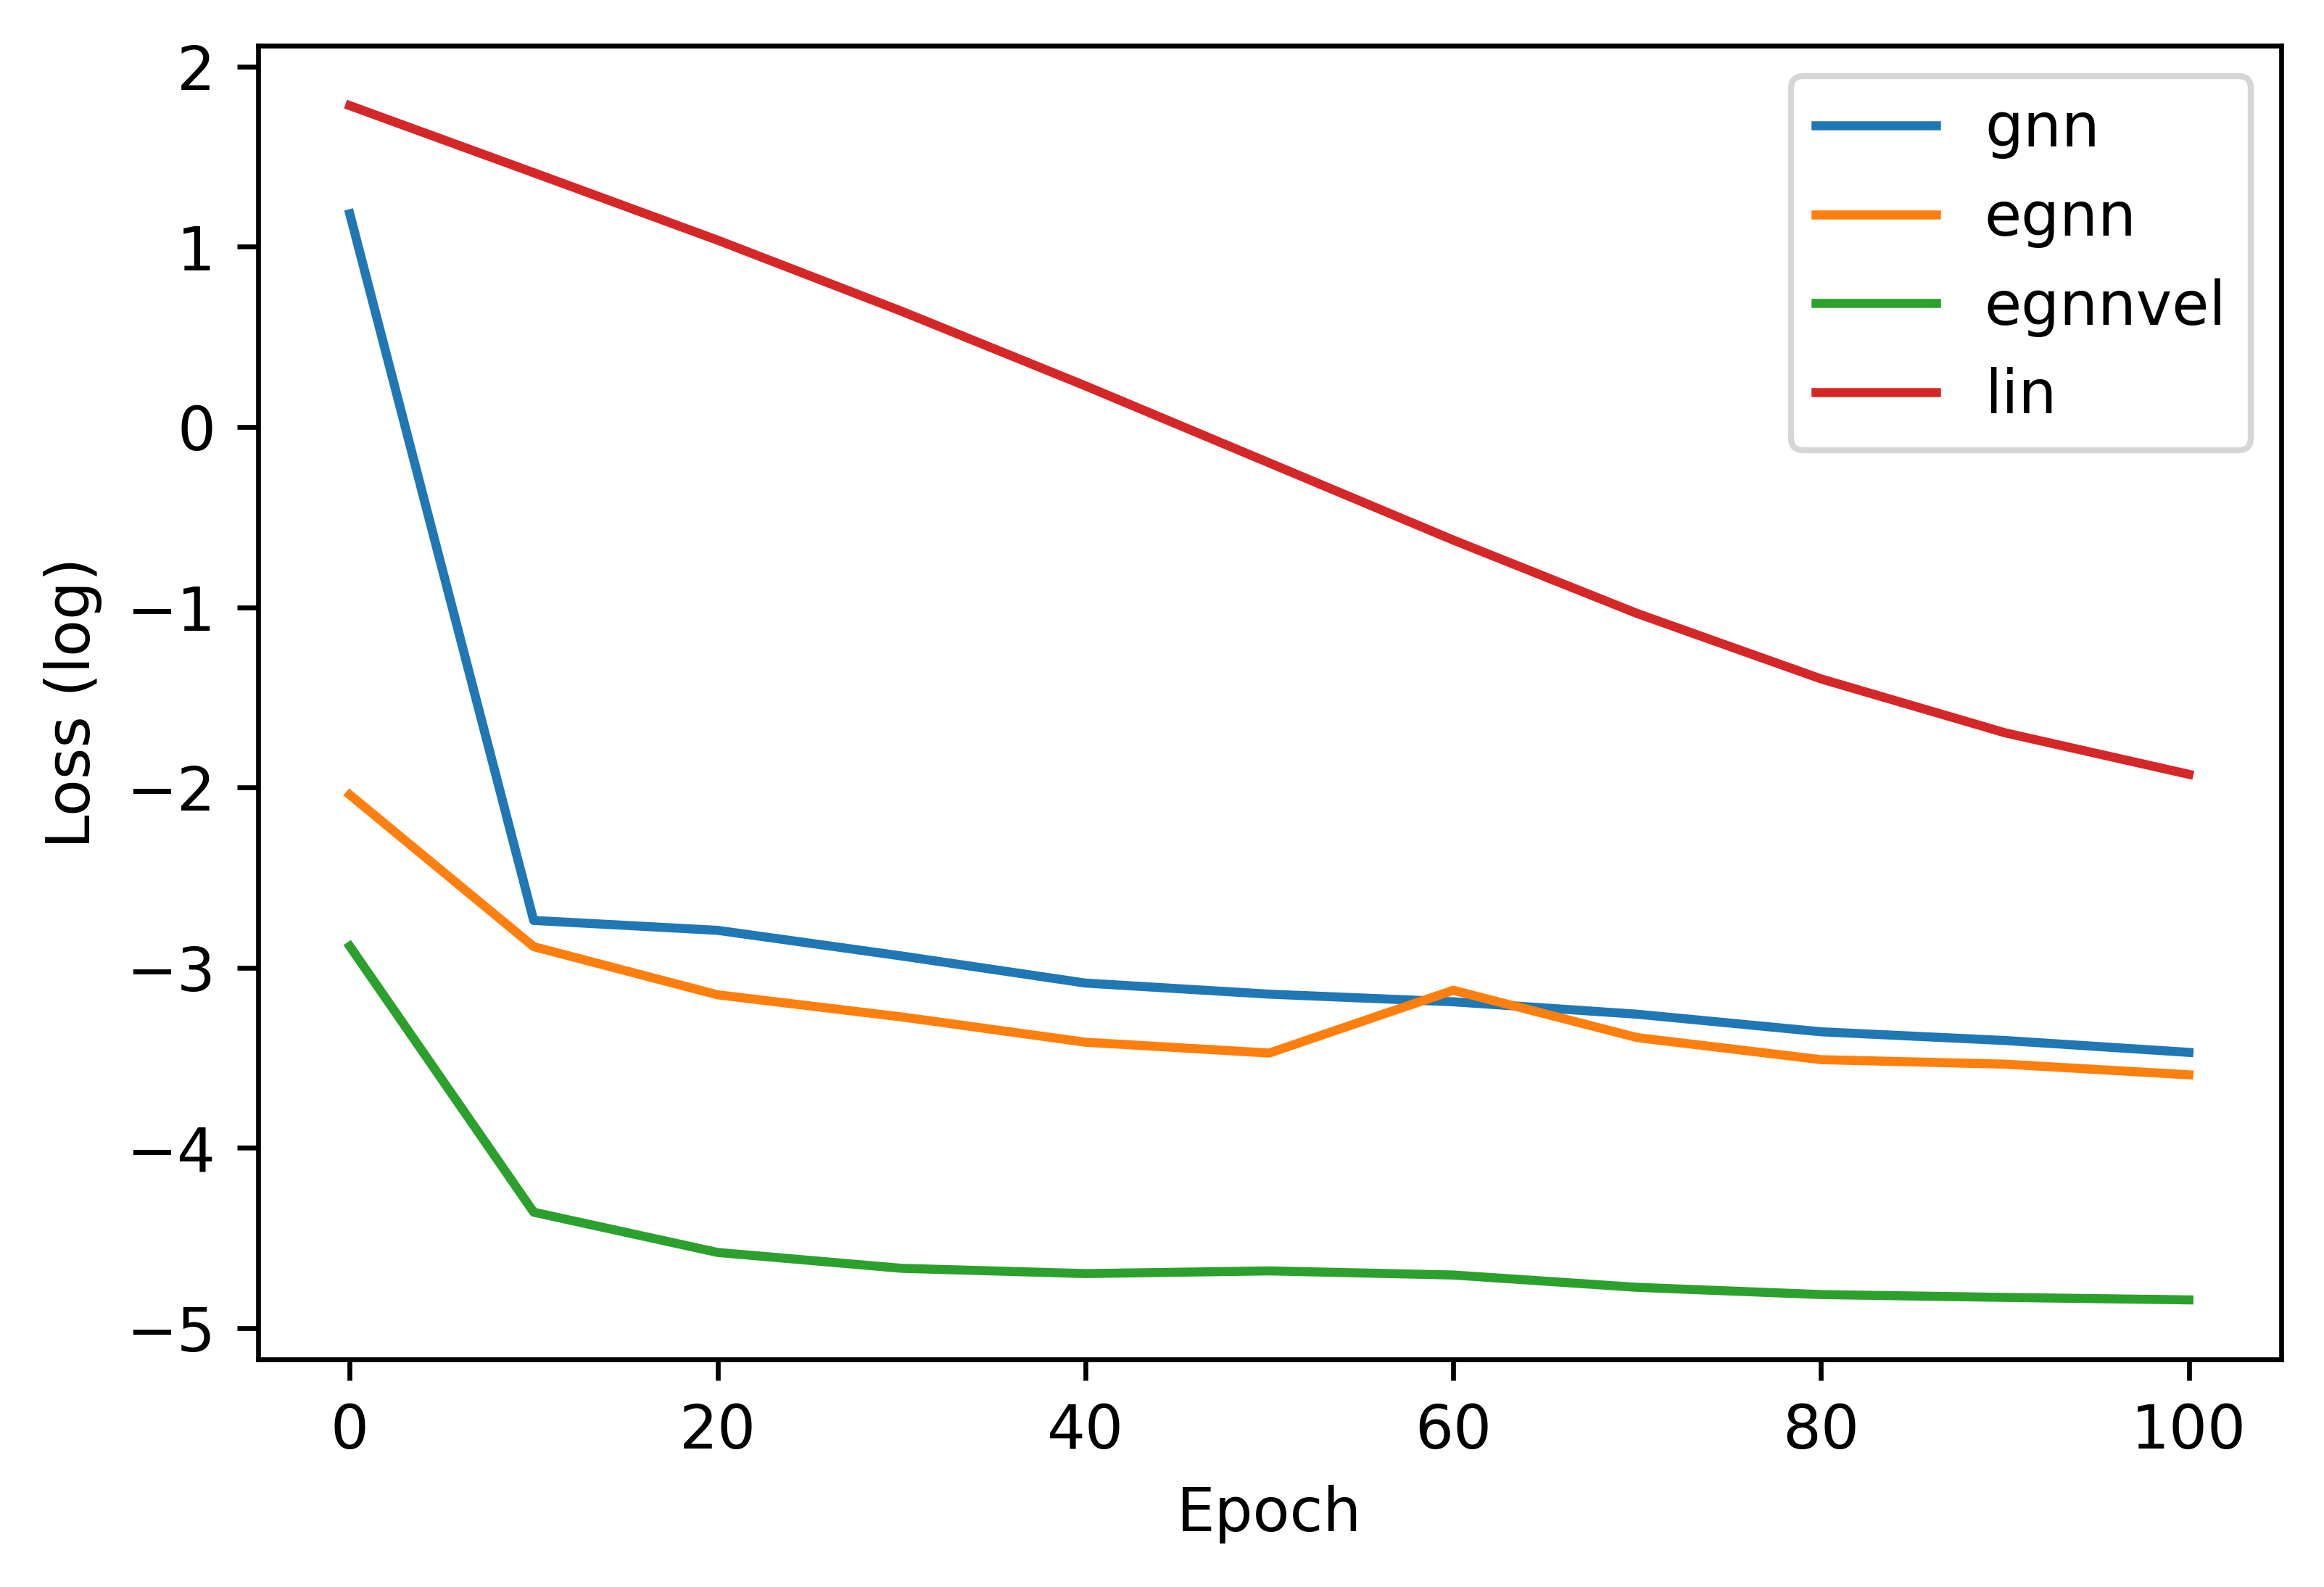

In [180]:
fig, ax = plt.subplots(dpi=600)
for k, v in results.items():
    ax.plot(v['epoch'], np.log(np.array(v['losses'])), label=k)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (log)')
plt.show()

### b. QM9

In [190]:
from qm9 import utils as qm9_utils

### c. Denoising